# Como anda o tempo médio de execução da sua equipe?
    Até o momento, dia 22/12/2023, eu trabalho no Departamento municipal de água e esgoto (DMAE) e me pediram uma forma de estudar a performance das equipes de água, esgoto e drenagem com a ideia de que o usuário (gerente do setor) podesse analisar semanalmente a produção da sua equipe.
    A partir do exposto, adquiri os dados e comecei os estudos necessários.

## Variaveis utilizadas para o estudo

In [55]:
variavel_limite_inferior_tipo_servico = 100

## Importando dados

In [56]:
import pandas as pd
import seaborn as sns                     
import matplotlib.pyplot as plt
%matplotlib inline     
sns.set(color_codes=True)

In [57]:
arquivo = r'C:\Users\300780\Desktop\Projeto equipes\ft_tge.csv'
df = pd.read_csv(arquivo, low_memory=False)

## Verificando os tipos dos dados

In [58]:
df.dtypes

dt_inicio_desloc     object
dt_fim_desloc        object
dt_solicitacao       object
dt_ano                int64
nm_logradouro        object
                     ...   
nr_ordem_servico      int64
cd_equipe           float64
cd_logradouro         int64
cd_bairro             int64
cd_servico            int64
Length: 24, dtype: object

##  Apagando colunas desnecessárias
Algumas colunas serão apagadas do estudo mesmo fazendo sentido para o projeto em questão, uma vez que os servidores não possuiam o habito em alimenta-las de forma correta. 
Baseando-se na forma como eles alimentavam os dados, por meio de reuniões e comentários, serão abordados apenas dados alimentados com maior zelo por parte dos servidores.


In [59]:
df = df.drop(['dt_solicitacao','data_exec','nm_logradouro','tp_logradouro','nr_imovel_lograd','nm_bairro_cidade','hr_padrao','dt_inicio_des_real','dt_final_des_real','gasto','gasto1','gasto2','nr_requis_ord_serv','cd_logradouro','cd_bairro'],axis=1)

In [60]:
df.dtypes

dt_inicio_desloc       object
dt_fim_desloc          object
dt_ano                  int64
dt_execucao_serv       object
dt_inicio_ocorrenc     object
dt_final_ocorrenc      object
nr_ordem_servico        int64
cd_equipe             float64
cd_servico              int64
dtype: object

# Informações básicas para o estudo
Vejo que é necessário compreender a quantidade de dados nulos para as colunas escolhidas

In [61]:
def porcentagem_nulos(dataframe):
    qtd_nulos = ((dataframe.isnull().sum()/len(dataframe))*100).round(2)
    return print(qtd_nulos)

show = porcentagem_nulos(df)
print(f'resgistros totais {len(df)}')
print(show)

dt_inicio_desloc      33.43
dt_fim_desloc         33.43
dt_ano                 0.00
dt_execucao_serv       0.00
dt_inicio_ocorrenc    81.70
dt_final_ocorrenc     81.70
nr_ordem_servico       0.00
cd_equipe             12.87
cd_servico             0.00
dtype: float64
resgistros totais 600536
None


Observando que dt_inicio_ocorrenc e dt_final_ocorrenc possui a maior parte dos dados comprometidos. Vou remove-los.


In [62]:
df = df.drop(["dt_inicio_ocorrenc","dt_final_ocorrenc","dt_fim_desloc"],axis=1)

# Renomeando colunas

In [63]:
df = df.rename(columns={
    "dt_inicio_desloc":"dt_inicio",
    "dt_ano":"ano",
    "dt_execucao_serv":"dt_execucao",
    "nr_ordem_servico":"ordem_servico",                 
})

In [64]:
df.head(5)

,dt_inicio,ano,dt_execucao,ordem_servico,cd_equipe,cd_servico
0,NaN,2021,2022-02-24 15:19:56,214687,495.0,2204
1,NaN,2021,2022-02-24 15:27:33,214584,495.0,2204
2,NaN,2021,2022-02-25 09:49:13,216791,484.0,2204
3,NaN,2021,2022-02-25 14:45:54,216870,483.0,2204
4,2021-10-14 07:10:00,2021,2021-10-14 07:20:00,54940,497.0,2204


## Verificando a viabilidade de usar o dt_inicio

#### Para dar mais credibilidade ao estudo de tempo, vou verificar se os dados que estão vazios na coluna "dt_inicio" são recentes ou não.
#### Diante disso, por meio da função value_counts(), fico sabendo a frequencia de cada dado que está vazio no dt_inicio

## Observando a quantidade de dados total

In [65]:
variedade_dados = df['ano'].value_counts()
print(variedade_dados)

2022    171680
2023    155220
2021    137309
2020     16461
2011     14346
         ...  
2018     10732
2017     10158
2015      9469
2002        11
2009         4
Name: ano, Length: 16, dtype: int64


## Observando a quantidade de dados com a coluna dt_inicio nula

In [66]:
df_null = df[df['dt_inicio'].isnull()] #filtrando tabela por dados vazios
variedade_dados_nulos= df_null['ano'].value_counts()
print(variedade_dados_nulos)

2021    42015
2022    18368
2011    14331
2012    13854
2013    13322
        ...  
2018    10466
2017    10107
2023    10003
2015     9438
2009        4
Name: ano, Length: 15, dtype: int64


In [13]:
relacao_nulos_total = f'{(variedade_dados_nulos/variedade_dados)*100}%'
print(relacao_nulos_total)

2002           NaN
2009    100.000000
2010     99.867684
2011     99.895441
2012     99.884643
2013     99.917498
2014     99.864968
2015     99.672616
2016     99.693997
2017     99.497933
2018     97.521431
2019     96.308199
2020     69.230302
2021     30.598868
2022     10.698975
2023      6.444401
Name: ano, dtype: float64%


#### Os dados nos mostram que há uma redução quanto ignorar o preenchimento dessa coluna nos últimos anos. O que me mostra que de maneira positiva, podemos levar em consideração o estudo de caso. 

## Criando a coluna duração e total segundos


In [14]:
df['dt_inicio'] = pd.to_datetime(df['dt_inicio'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['dt_execucao'] = pd.to_datetime(df['dt_execucao'], format='%Y-%m-%d %H:%M:%S', errors='coerce')



## Subtraindo  a coluna dt_execucao com a coluna dt_inicio

In [15]:
df['duracao'] = (df['dt_execucao'] - df['dt_inicio'])
df['total_segundos'] = (df['dt_execucao'] - df['dt_inicio']).dt.total_seconds()
df.head(10)

,dt_inicio,ano,dt_execucao,ordem_servico,cd_equipe,cd_servico,duracao,total_segundos
0,NaT,2021,2022-02-24 15:19:56,214687,495.0,2204,NaT,NaN
1,NaT,2021,2022-02-24 15:27:33,214584,495.0,2204,NaT,NaN
2,NaT,2021,2022-02-25 09:49:13,216791,484.0,2204,NaT,NaN
3,NaT,2021,2022-02-25 14:45:54,216870,483.0,2204,NaT,NaN
4,2021-10-14 07:10:00,2021,2021-10-14 07:20:00,54940,497.0,2204,0 days 00:10:00,600.0
5,2021-10-14 16:11:00,2021,2021-10-14 16:20:00,75358,435.0,2204,0 days 00:09:00,540.0
6,2021-10-14 08:26:00,2021,2021-10-14 08:35:00,58361,486.0,2204,0 days 00:09:00,540.0
7,NaT,2022,2022-02-11 14:34:38,45342,496.0,2204,NaT,NaN
8,2021-08-02 09:31:00,2021,2021-08-02 09:40:00,24314,484.0,2204,0 days 00:09:00,540.0
9,2021-08-02 14:22:00,2021,2021-08-02 14:39:00,52314,459.0,2204,0 days 00:17:00,1020.0


In [16]:
df.shape # Total de linhas


(600536, 8)

## Excluindo dados nulos

In [21]:
df_without_null = df.dropna(subset=['dt_inicio'])
df.shape # Total de linhas não nulas
df.head(5)

,dt_inicio,ano,dt_execucao,ordem_servico,cd_equipe,cd_servico,duracao,total_segundos
4,2021-10-14 07:10:00,2021,2021-10-14 07:20:00,54940,497.0,2204,0 days 00:10:00,600
5,2021-10-14 16:11:00,2021,2021-10-14 16:20:00,75358,435.0,2204,0 days 00:09:00,540
6,2021-10-14 08:26:00,2021,2021-10-14 08:35:00,58361,486.0,2204,0 days 00:09:00,540
8,2021-08-02 09:31:00,2021,2021-08-02 09:40:00,24314,484.0,2204,0 days 00:09:00,540
9,2021-08-02 14:22:00,2021,2021-08-02 14:39:00,52314,459.0,2204,0 days 00:17:00,1020


## Mudando o tipo dos dados

In [22]:
df_without_null['total_segundos'] = df_without_null['total_segundos'].astype(int)
df_without_null['cd_servico'] = df_without_null['cd_servico'].astype(str)
df_without_null['cd_equipe'] = df_without_null['cd_equipe'].astype(str)


In [23]:
df_without_null.dtypes

dt_inicio          datetime64[ns]
ano                         int64
dt_execucao        datetime64[ns]
ordem_servico               int64
cd_equipe                  object
cd_servico                 object
duracao           timedelta64[ns]
total_segundos              int32
dtype: object

# Inicializando estudos estatísticos mais detalhados

#### Como uma análise estatística com pouca amostragem me mostra uma distorção e um resultado errôneo. Nesse caso, vou optar por considerar apenas serviços com mais de 100 amostragens. 

In [67]:
contagem_tipo_servico = df_without_null['cd_servico'].value_counts()
print(contagem_tipo_servico)

2204    67671
2264    20901
2106    18813
3061    12375
1209    10063
        ...  
2085        1
1902        1
1906        1
9996        1
7107        1
Name: cd_servico, Length: 436, dtype: int64


In [54]:
mais_cem = contagem_tipo_servico[contagem_tipo_servico >= variavel_limite_inferior_tipo_servico].index
df_notnull_filtrado = df_without_null[df_without_null['cd_servico'].isin(mais_cem)]
contagem_tipo_servico_filtrado = df_notnull_filtrado['cd_servico'].value_counts()
print(contagem_tipo_servico_filtrado)

2204    67671
2264    20901
2106    18813
3061    12375
1209    10063
        ...  
2650      113
6162      112
2610      111
3199      106
1003      100
Name: cd_servico, Length: 150, dtype: int64


#### Mostrando os serviços que entram no filtro

In [25]:
tipo_produtos = df_notnull_filtrado["cd_servico"].unique()
print(tipo_produtos)

['2204' '2203' '2202' '2140' '2138' '2139' '2137' '2122' '2134' '2131'
 '2121' '2118' '2120' '2106' '2108' '2071' '2101' '2072' '2070' '2004'
 '2000' '1930' '1929' '2069' '2067' '2019' '2006' '2003' '1926' '1215'
 '1214' '1924' '1209' '1048' '1020' '1920' '1909' '1216' '1208' '1207'
 '1053' '1054' '1052' '1046' '1035' '1037' '1034' '1026' '1025' '1024'
 '1023' '1022' '1021' '1019' '1008' '1004' '1003' '10000' '9998' '9990'
 '9997' '7310' '7305' '7304' '7156' '7113' '6194' '6189' '6150' '6149'
 '6183' '6174' '6173' '6157' '6152' '6151' '6171' '6169' '6167' '6164'
 '6162' '6153' '6148' '6147' '6145' '6144' '6135' '4083' '4082' '4081'
 '3214' '4079' '4077' '3900' '3260' '3196' '3117' '3199' '3064' '3062'
 '3061' '3194' '3191' '3193' '3190' '3060' '3100' '3063' '3059' '3003'
 '3001' '3015' '2650' '2640' '2630' '2621' '2620' '2616' '2610' '2604'
 '2419' '2400' '2299' '2264' '2262' '2260' '2257' '2250' '2244' '2249'
 '2243' '2242' '2240' '2235' '2234' '2233' '2231' '2230' '2229' '2227'
 '222

## Média de cada serviço antes da exclusão de outliers

#### Mudando características do pandas para melhor visualização

In [26]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [27]:
media_tipo_servico = df_notnull_filtrado.groupby('cd_servico')['total_segundos'].mean()
print(media_tipo_servico)

cd_servico
10000       1160.26
1003        3106.19
1004       19116.71
1008        9052.61
1019        2259.78
1020      -16554.08
1021        4728.56
1022        2762.12
1023        3923.91
1024        6203.91
1025      227159.63
1026     -542658.10
1034       11547.97
1035       36941.21
1037       11976.13
1046        9693.17
1048        2741.12
1052        1690.00
1053        3703.60
1054        5013.39
1207       38506.47
1208       23759.97
1209        1509.84
1214      130733.50
1215        1711.53
1216        6063.94
1909       21667.16
1920         831.36
1924      350457.72
1926        9724.69
1929       42622.01
1930        6905.75
2000        3093.72
2003        3317.95
2004        3559.56
2006        5876.63
2019        2905.77
2067        8125.65
2069        5016.68
2070      185163.97
2071        7084.58
2072        8241.61
2101        2307.20
2106        1673.88
2108        1331.76
2118        1342.43
2120        1008.97
2121         913.24
2122       33601.72
2131     

#### Voltando as características do pandas ao estágio inicial para evitar lag

In [51]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

## Observando outliers e o comportamento dos dados de cada serviço

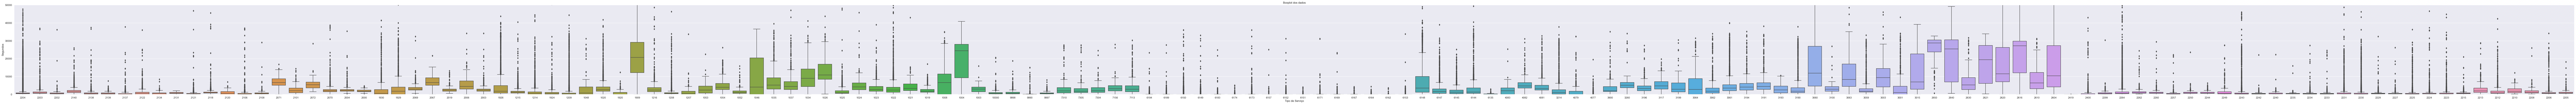

In [68]:
plt.figure(figsize=(200, 7))
plt.title('Boxplot dos dados')
plt.ylim(0,50000)
ax = sns.boxplot(x=df_notnull_filtrado['cd_servico'], y=df_notnull_filtrado['total_segundos'])
ax.set(xlabel='Tipo de Serviço', ylabel='Segundos')
plt.show()

## Apagando outliers pelo método Intervalo interquartil (IQR)

In [69]:
def remove_outliers_por_tipo(df, coluna):
    df_sem_outliers = pd.DataFrame()
    
    for tipo, grupo in df.groupby('cd_servico'):
        Q1 = grupo[coluna].quantile(0.25)
        Q3 = grupo[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        grupo_sem_outliers = grupo[(grupo[coluna] >= limite_inferior) & (grupo[coluna] <= limite_superior)]
        df_sem_outliers = pd.concat([df_sem_outliers, grupo_sem_outliers])

    return df_sem_outliers
    
df_limpo = remove_outliers_por_tipo(df_notnull_filtrado, 'total_segundos')


## Média de cada serviço depois da exclusão de outliers

In [71]:
df_limpo.sort_values(by='cd_servico')
media_tipo_servico = df_limpo.groupby('cd_servico')['total_segundos'].mean()
print(media_tipo_servico)

cd_servico
10000      665.058752
1003      2909.989796
1004     19116.706349
1008      6695.165049
1019      1910.202518
             ...     
7305      2049.330435
7310      2327.513514
9990        43.844211
9997       580.969479
9998       711.832647
Name: total_segundos, Length: 150, dtype: float64


#### Ao observar o resultado da média de cada serviço, compreendo que há dados que diminuiram seu tempo médio, uma vez que dados outliers foram retirados. Mas me veio o questionamento, por que o serviço 1004 manteve sua média sem alteração? Observando o boxplot, esse serviço não possuia nenhum outlier, então nenhum dado dele foi retirado. Assim, me veio outro ponto, quantos serviços registrados temos com esse código de serviço?
* Voltando um pouco no pojeto, observo que o serviço 1004 só possui 126 registros e que ainda é muito cedo para definir algo sobre ele. Semelhante a essa amostragem, temos os códigos 1026,1048 entre outros.

* Se o código possuisse uma amostragem grande e ainda assim, possuisse um medida de dispersão grande, seria um bom serviço para rever como ele está sendo executado. Provavelmente teria uma boa margem para melhorar seu processo.

* Códigos que possuem um boxplot muito pequeno mesmo tendo uma amostragem superior a 1000, sugere que as pessoas iniciam e finalizam o serviço no mesmo momento e não representa seu real tempo de execução.

* Somente para título de curiosidade, foram retirados dados nulos do estudo, para um estudo mais detalhado, seria necessário que os colaboradores preenchessem os dados com mais detalhe.

* Uma das colunas retiradas, como a coluna "dt_inicio_ocorrencia" não possuia nenhum dado e seria uma ótima coluna para ter um estudo mais aprofundado e detalhado do processo.

______________________________________________________________________

# Conclusão

&nbsp;&nbsp;&nbsp;No estudo de caso em questão, foi feito um recorte dos dados para um estudo detalhado. Agora que temos um resultado, podemos iniciar com maior vigor , uma comparação com os serviços novos atualizando a lista para verificar se eles estão acima ou abaixo da média. O objetivo é termos um tempo de execução hábil sem perder a qualidade defendida do serviço.<br />
&nbsp;&nbsp;&nbsp;Após realizar a limpeza dos dados, compreende-se que temos muito o que melhorar quanto a inserção de dados, e que por meio dos estudos, verifica-se que há uma perda de  mais de 50% dos dados. O que me mantém mais otimista é o fato de que os dados mais concisos são dados mais recentes e que por meio deles, podemos ter um início mais rápido.<br />